In [1]:
%matplotlib inline
import os
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import re
import string
import shutil

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn

import sklearn as sk
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

from gensim.models import KeyedVectors

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, LSTM, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm, tqdm_notebook, tnrange, trange
import hyperas
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe, STATUS_FAIL
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
tqdm.monitor_interval = 0
sn.set_context('notebook')

## Prepare Sequences

In [3]:
train = pd.read_pickle('CLEAN/train.P.gz', compression='gzip')
test = pd.read_pickle('CLEAN/test.P.gz', compression='gzip')

In [4]:
train.iloc[0:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,False,False,False,False,False,explanation why the edit make under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,False,False,False,False,False,daww he match this background colour I be seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,False,False,False,False,False,hey man I be really not try to edit war its ju...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,False,False,False,False,False,more I can not make any real suggestion on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,False,False,False,False,False,you sir be my hero any chance you remember wha...


In [5]:
print(train.shape)
print(test.shape)
all_texts = pd.concat((train['cleaned_comments'], test['cleaned_comments']), axis='rows')
print(all_texts.shape)

(159571, 9)
(153164, 3)
(312735,)


In [6]:
# MAX_NUM_WORDS=400000
MAX_NUM_WORDS=25000

In [7]:
tokenizer=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(train['cleaned_comments'])
test_sequences = tokenizer.texts_to_sequences(test['cleaned_comments'])

In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 396618 unique tokens.


In [9]:
train_seq_lens = list()
for seq in train_sequences:
    train_seq_lens.append(len(seq))
test_seq_lens = list()
for seq in test_sequences:
    test_seq_lens.append(len(seq))


In [10]:
print(max(train_seq_lens))
print(max(test_seq_lens))

1400
2142


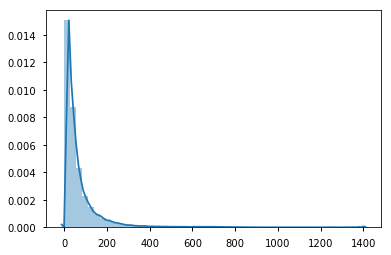

In [11]:
sn.distplot(train_seq_lens)

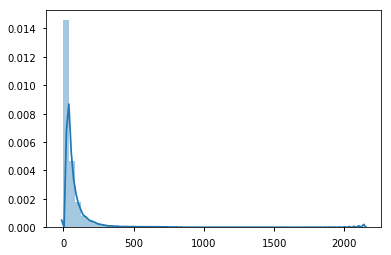

In [12]:
sn.distplot(test_seq_lens)

In [13]:
# MAX_SEQUENCE_LENGTH = 2150
MAX_SEQUENCE_LENGTH = 400
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Prepare Embeddings

In [14]:
EMBEDDING_DIM=100

In [15]:
embeddings_index = dict()
with open('GLOVE/glove.twitter.27B.%dd.txt' % EMBEDDING_DIM, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word not in word_index or word_index[word] > MAX_NUM_WORDS:
            continue
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 21434 word vectors.


In [16]:
embedding_matrix = np.zeros((MAX_NUM_WORDS + 1, EMBEDDING_DIM))
for word, i in tqdm_notebook(word_index.items()):
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

HBox(children=(IntProgress(value=0, max=396618), HTML(value='')))

In [17]:
embedding_matrix.shape

(25001, 100)

## Serialize Objects

In [18]:
import pickle
with open("NN_INPUTS/train.seq.P", 'wb') as f:
     pickle.dump(train_data, f)
with open("NN_INPUTS/test.seq.P", 'wb') as f:
     pickle.dump(test_data, f)
with open("NN_INPUTS/embedding.matrix.P", 'wb') as f:
    pickle.dump(embedding_matrix, f)
with open("NN_INPUTS/word_index.P", 'wb') as f:
    pickle.dump(word_index, f)

In [19]:
import gc

In [20]:
gc.collect()

820